# First usecase just to make sure everything is working fine

In [ ]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv()

endpoint = os.getenv("AZURE_MISTRAL_API_ENDPOINT")
model_name = "mistral-small-2503"

client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(os.getenv("AZURE_API_KEY")),
    api_version="2024-05-01-preview"
)

response = client.complete(
    messages=[
        SystemMessage(content="You are a helpful assistant."),
        UserMessage(content="I am going to Paris, what should I see?"),
    ],
    max_tokens=2048,
    temperature=0.8,
    top_p=0.1,
    model=model_name
)

print(response.choices[0].message.content)

Paris is a city rich in history, culture, and beauty. Here are some must-see attractions and experiences you shouldn't miss:

1. **Eiffel Tower**: An iconic symbol of Paris, you can either admire it from the ground or take a lift to the top for a breathtaking view of the city.

2. **Louvre Museum**: Home to thousands of works of art, including the Mona Lisa and the Winged Victory. The museum is housed in the Louvre Palace, a former royal residence.

3. **Notre-Dame Cathedral**: Although severely damaged by a fire in 2019, the cathedral remains an important historical and architectural landmark. Restoration work is ongoing.

4. **Montmartre**: Known for its bohemian past, charming streets, and the stunning Sacré-Cœur Basilica at its summit. Don't miss Place du Tertre, where local artists create and sell their work.

5. **Champs-Élysées and Arc de Triomphe**: Stroll down the famous avenue, lined with luxury shops and cafes, and visit the iconic Arc de Triomphe at its end.

6. **Seine Riv

# How to analyze an image

Note the following requirements for image analysis:

- The image must be presented in JPEG, PNG, GIF, or BMP format.
- The file size of the image must be less than 4 megabytes (MB).
- The dimensions of the image must be greater than 50 x 50 pixels.


In [1]:
import os
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

client = ImageAnalysisClient(
    endpoint=os.getenv("AZURE_CV4_ENDPOINT"),
    credential=AzureKeyCredential(os.getenv("AZURE_CV4_KEY"))
)

result = client.analyze_from_url(
    image_url="https://www.zooplus.fr/magazine/wp-content/uploads/2023/05/corgi-1.jpeg", # Binary data from your image file
    visual_features=[VisualFeatures.TAGS]
)

for tag in result["tagsResult"]["values"]:
    print(tag["name"])

animal
mammal
pet
dog
outdoor
dog breed
grass
snout
corgi
ground
brown
looking


## Exercise - Analyze images

In [ ]:
from dotenv import load_dotenv
import os
from PIL import Image, ImageDraw
import sys
from matplotlib import pyplot as plt
from azure.core.exceptions import HttpResponseError
import requests

# import namespaces
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential


def main():

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        ai_endpoint = os.getenv('AZURE_CV4_ENDPOINT')
        ai_key = os.getenv('AZURE_CV4_KEY')

        # Get image
        image_file = 'images/street.jpg'
        if len(sys.argv) > 1:
            image_file = sys.argv[1]
        

        # Authenticate Azure AI Vision client
        cv_client = ImageAnalysisClient(
            endpoint=ai_endpoint,
            credential=AzureKeyCredential(ai_key))


        # Analyze image
        with open(image_file, "rb") as f:
            image_data = f.read()
        print(f'\nAnalyzing {image_file}\n')

        result = cv_client.analyze(
            image_data=image_data,
            visual_features=[
                VisualFeatures.CAPTION,
                VisualFeatures.DENSE_CAPTIONS,
                VisualFeatures.TAGS,
                VisualFeatures.OBJECTS,
                VisualFeatures.PEOPLE],
        )


        # Get image captions
        if result.caption is not None:
            print("\nCaption:")
            print(" Caption: '{}' (confidence: {:.2f}%)".format(result.caption.text, result.caption.confidence * 100))
            
        if result.dense_captions is not None:
            print("\nDense Captions:")
            for caption in result.dense_captions.list:
                print(" Caption: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))
        

        # Get image tags
        if result.tags is not None:
            print("\nTags:")
            for tag in result.tags.list:
                print(" Tag: '{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))


        # Get objects in the image
        if result.objects is not None:
            print("\nObjects in image:")
            for detected_object in result.objects.list:
                # Print object tag and confidence
                print(" {} (confidence: {:.2f}%)".format(detected_object.tags[0].name, detected_object.tags[0].confidence * 100))
            # Annotate objects in the image
            show_objects(image_file, result.objects.list)


        # Get people in the image
        if result.people is not None:
            print("\nPeople in image:")

            for detected_person in result.people.list:
                if detected_person.confidence > 0.2:
                    # Print location and confidence of each person detected
                    print(" {} (confidence: {:.2f}%)".format(detected_person.bounding_box, detected_person.confidence * 100))
            # Annotate people in the image
            show_people(image_file, result.people.list)
  
            
        
    except Exception as ex:
        print(ex)


def show_objects(image_filename, detected_objects):
    print ("\nAnnotating objects...")

    # Prepare image for drawing
    image = Image.open(image_filename)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for detected_object in detected_objects:
        # Draw object bounding box
        r = detected_object.bounding_box
        bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height)) 
        draw.rectangle(bounding_box, outline=color, width=3)
        plt.annotate(detected_object.tags[0].name,(r.x, r.y), backgroundcolor=color)

    # Save annotated image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    objectfile = 'objects.jpg'
    fig.savefig(objectfile)
    print('  Results saved in', objectfile)


def show_people(image_filename, detected_people):
    print ("\nAnnotating objects...")

    # Prepare image for drawing
    image = Image.open(image_filename)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for detected_person in detected_people:
        if detected_person.confidence > 0.2:
            # Draw object bounding box
            r = detected_person.bounding_box
            bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height))
            draw.rectangle(bounding_box, outline=color, width=3)

    # Save annotated image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    peoplefile = 'people.jpg'
    fig.savefig(peoplefile)
    print('  Results saved in', peoplefile)


if __name__ == "__main__":
    main()


# Img-to-text (optical character recognition)

In [3]:
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

client = ImageAnalysisClient(
    endpoint=os.getenv("AZURE_CV_ENDPOINT"),
    credential=AzureKeyCredential(os.getenv("AZURE_API_KEY"))
)

result = client.analyze_from_url(
    image_url="https://myminimalplanner.com/cdn/shop/files/RecipeCheck.jpg?v=1746749084&width=2000", # Binary data from your image file
    visual_features=[VisualFeatures.READ],
    language="en",
)
print(result)

{'modelVersion': '2023-10-01', 'metadata': {'width': 2000, 'height': 2000}, 'readResult': {'blocks': [{'lines': [{'text': '# OF SERVINGS', 'boundingPolygon': [{'x': 858, 'y': 258}, {'x': 1005, 'y': 232}, {'x': 1008, 'y': 257}, {'x': 862, 'y': 282}], 'words': [{'text': '#', 'boundingPolygon': [{'x': 858, 'y': 260}, {'x': 872, 'y': 257}, {'x': 877, 'y': 280}, {'x': 863, 'y': 282}], 'confidence': 0.991}, {'text': 'OF', 'boundingPolygon': [{'x': 879, 'y': 256}, {'x': 905, 'y': 250}, {'x': 909, 'y': 274}, {'x': 883, 'y': 278}], 'confidence': 0.997}, {'text': 'SERVINGS', 'boundingPolygon': [{'x': 910, 'y': 249}, {'x': 1005, 'y': 232}, {'x': 1007, 'y': 259}, {'x': 914, 'y': 273}], 'confidence': 0.993}]}, {'text': 'TOTAL TIME', 'boundingPolygon': [{'x': 717, 'y': 280}, {'x': 827, 'y': 267}, {'x': 830, 'y': 287}, {'x': 721, 'y': 304}], 'words': [{'text': 'TOTAL', 'boundingPolygon': [{'x': 719, 'y': 281}, {'x': 776, 'y': 274}, {'x': 779, 'y': 296}, {'x': 722, 'y': 304}], 'confidence': 0.994}, {'

## Exercise - Read text in images

In [ ]:
from dotenv import load_dotenv
import os
import time
import sys
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

# import namespaces
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential



def main():

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        ai_endpoint = os.getenv('AZURE_CV4_ENDPOINT')
        ai_key = os.getenv('AZURE_CV4_KEY')

        # Get image
        image_file = 'images/Lincoln.jpg'
        if len(sys.argv) > 1:
            image_file = sys.argv[1]


        # Authenticate Azure AI Vision client
        cv_client = ImageAnalysisClient(
            endpoint=ai_endpoint,
            credential=AzureKeyCredential(ai_key))

        
        # Read text in image
        with open(image_file, "rb") as f:
            image_data = f.read()
        print (f"\nReading text in {image_file}")

        result = cv_client.analyze(
            image_data=image_data,
            visual_features=[VisualFeatures.READ])
        

        # Print the text
        if result.read is not None:
            print("\nText:")
            
            for line in result.read.blocks[0].lines:
                print(f" {line.text}")        
            # Annotate the text in the image
            annotate_lines(image_file, result.read)

            # Find individual words in each line
            print ("\nIndividual words:")
            for line in result.read.blocks[0].lines:
                for word in line.words:
                    print(f"  {word.text} (Confidence: {word.confidence:.2f}%)")
            # Annotate the words in the image
            annotate_words(image_file, result.read)
        
        


    except Exception as ex:
        print(ex)

def annotate_lines(image_file, detected_text):
    print(f'\nAnnotating lines of text in image...')

     # Prepare image for drawing
    image = Image.open(image_file)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for line in detected_text.blocks[0].lines:
        # Draw line bounding polygon
        r = line.bounding_polygon
        rectangle = ((r[0].x, r[0].y),(r[1].x, r[1].y),(r[2].x, r[2].y),(r[3].x, r[3].y))
        draw.polygon(rectangle, outline=color, width=3)

    # Save image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    textfile = 'lines.jpg'
    fig.savefig(textfile)
    print('  Results saved in', textfile)
    
def annotate_words(image_file, detected_text):
    print(f'\nAnnotating individual words in image...')

     # Prepare image for drawing
    image = Image.open(image_file)
    fig = plt.figure(figsize=(image.width/100, image.height/100))
    plt.axis('off')
    draw = ImageDraw.Draw(image)
    color = 'cyan'

    for line in detected_text.blocks[0].lines:
        for word in line.words:
            # Draw word bounding polygon
            r = word.bounding_polygon
            rectangle = ((r[0].x, r[0].y),(r[1].x, r[1].y),(r[2].x, r[2].y),(r[3].x, r[3].y))
            draw.polygon(rectangle, outline=color, width=3)

    # Save image
    plt.imshow(image)
    plt.tight_layout(pad=0)
    textfile = 'words.jpg'
    fig.savefig(textfile)
    print('  Results saved in', textfile)



if __name__ == "__main__":
    main()


# Face recognition

The Face service provides functionality that you can use for:

- Face detection - for each detected face, the results include an ID that identifies the face and the bounding box coordinates indicating its location in the image.
- Face attribute analysis - you can return a wide range of facial attributes, including:
- Head pose (pitch, roll, and yaw orientation in 3D space)
    - Glasses (No glasses, Reading glasses, Sunglasses, or Swimming Goggles)
    - Mask (the presence of a face mask)
    - Blur (low, medium, or high)
    - Exposure (under exposure, good exposure, or over exposure)
    - Noise (visual noise in the image)
    - Occlusion (objects obscuring the face)
    - Accessories (glasses, headwear, mask)
    - QualityForRecognition (low, medium, or high)
- Facial landmark location - coordinates for key landmarks in relation to facial features (for example, eye corners, pupils, tip of nose, and so on)
- Face comparison - you can compare faces across multiple images for similarity (to find individuals with similar facial features) and verification (to determine that a face in one image is the same person as a face in another image)
- Facial recognition - you can train a model with a collection of faces belonging to specific individuals, and use the model to identify those people in new images.
- Facial liveness - liveness can be used to determine if the input video is a real stream or a fake to prevent bad-intentioned individuals from spoofing a facial recognition system.

In [ ]:
import os
from azure.ai.vision.face import FaceClient
from azure.ai.vision.face.models import *
from azure.core.credentials import AzureKeyCredential

face_client = FaceClient(
    endpoint=os.getenv("AZURE_FACE_END"),
    credential=AzureKeyCredential(os.getenv("AZURE_FACE_KEY")))

features = [FaceAttributeTypeDetection01.HEAD_POSE,
            FaceAttributeTypeDetection01.OCCLUSION,
            FaceAttributeTypeDetection01.ACCESSORIES]

# Use client to detect faces in an image
with open("mslearn-ai-vision/Labfiles/analyze-images/python/image-analysis/images/person.jpg", mode="rb") as image_data:
    detected_faces = face_client.detect(
        image_content=image_data.read(),
        detection_model=FaceDetectionModel.DETECTION01,
        recognition_model=FaceRecognitionModel.RECOGNITION01,
        return_face_id=True,
        return_face_attributes=features,
    )


In [ ]:
from dotenv import load_dotenv
import os
import sys
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

# Import namespaces
from azure.ai.vision.face import FaceClient
from azure.ai.vision.face.models import FaceDetectionModel, FaceRecognitionModel, FaceAttributeTypeDetection01
from azure.core.credentials import AzureKeyCredential


def main():

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        cog_endpoint = os.getenv('AZURE_FACE_END')
        cog_key = os.getenv('AZURE_FACE_KEY')

        # Get image
        image_file = 'images/face1.jpg'
        if len(sys.argv) > 1:
            image_file = sys.argv[1]


        # Authenticate Face client
        face_client = FaceClient(
            endpoint=cog_endpoint,
            credential=AzureKeyCredential(cog_key))



        # Specify facial features to be retrieved
        features = [FaceAttributeTypeDetection01.HEAD_POSE,
                    FaceAttributeTypeDetection01.OCCLUSION,
                    FaceAttributeTypeDetection01.ACCESSORIES]


        ## Get faces
        with open(image_file, mode="rb") as image_data:
            detected_faces = face_client.detect(
                image_content=image_data.read(),
                detection_model=FaceDetectionModel.DETECTION01,
                recognition_model=FaceRecognitionModel.RECOGNITION01,
                return_face_id=False,
                return_face_attributes=features,
            )

        face_count = 0
        if len(detected_faces) > 0:
            print(len(detected_faces), 'faces detected.')
            for face in detected_faces:
            
                # Get face properties
                face_count += 1
                print('\nFace number {}'.format(face_count))
                print(' - Head Pose (Yaw): {}'.format(face.face_attributes.head_pose.yaw))
                print(' - Head Pose (Pitch): {}'.format(face.face_attributes.head_pose.pitch))
                print(' - Head Pose (Roll): {}'.format(face.face_attributes.head_pose.roll))
                print(' - Forehead occluded?: {}'.format(face.face_attributes.occlusion["foreheadOccluded"]))
                print(' - Eye occluded?: {}'.format(face.face_attributes.occlusion["eyeOccluded"]))
                print(' - Mouth occluded?: {}'.format(face.face_attributes.occlusion["mouthOccluded"]))
                print(' - Accessories:')
                for accessory in face.face_attributes.accessories:
                    print('   - {}'.format(accessory.type))
                # Annotate faces in the image
                annotate_faces(image_file, detected_faces)
 
 

    except Exception as ex:
        print(ex)

def annotate_faces(image_file, detected_faces):
    print('\nAnnotating faces in image...')

    # Prepare image for drawing
    fig = plt.figure(figsize=(8, 6))
    plt.axis('off')
    image = Image.open(image_file)
    draw = ImageDraw.Draw(image)
    color = 'lightgreen'

    # Annotate each face in the image
    face_count = 0
    for face in detected_faces:
        face_count += 1
        r = face.face_rectangle
        bounding_box = ((r.left, r.top), (r.left + r.width, r.top + r.height))
        draw = ImageDraw.Draw(image)
        draw.rectangle(bounding_box, outline=color, width=5)
        annotation = 'Face number {}'.format(face_count)
        plt.annotate(annotation,(r.left, r.top), backgroundcolor=color)
    
    # Save annotated image
    plt.imshow(image)
    outputfile = 'detected_faces.jpg'
    fig.savefig(outputfile)
    print(f'  Results saved in {outputfile}\n')


if __name__ == "__main__":
    main()

# Clasify img

## Azure AI Custom Vision

The Azure AI Custom Vision service enables you to build your own computer vision models for image classification or object detection.

To use the Custom Vision service to create a solution, you need two Custom Vision resources in your Azure subscription:

- An Azure AI Custom Vision training resource - used to train a custom model based on your own training images.
- An Azure AI Custom Vision prediction resource - used to generate predictions from new images based on your trained model.

In [ ]:
from msrest.authentication import ApiKeyCredentials
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient


 # Authenticate a client for the prediction API
credentials = ApiKeyCredentials(in_headers={"Prediction-key": "<YOUR_PREDICTION_RESOURCE_KEY>"})
prediction_client = CustomVisionPredictionClient(endpoint="<YOUR_PREDICTION_RESOURCE_ENDPOINT>",
                                                 credentials=credentials)

# Get classification predictions for an image
image_data = open("/Users/A200315276/Desktop/AI_Engineer/mslearn-ai-vision/Labfiles/image-classification/test-images/IMG_TEST_1.jpg", "rb").read()
results = prediction_client.classify_image("<YOUR_PROJECT_ID>",
                                           "<YOUR_PUBLISHED_MODEL_NAME>",
                                           image_data)

# Process predictions
for prediction in results.predictions:
    if prediction.probability > 0.5:
        print(image, ': {} ({:.0%})'.format(prediction.tag_name, prediction.probability))

## Exercise - Classify images

In [5]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
import os

def main():
    from dotenv import load_dotenv
    global training_client
    global custom_vision_project

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        training_endpoint = os.getenv('AZURE_CLAS_END')
        training_key = os.getenv('AZURE_CLAS_KEY')
        project_id = os.getenv('AZURE_CLAS_PID')

        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
        training_client = CustomVisionTrainingClient(training_endpoint, credentials)

        # Get the Custom Vision project
        custom_vision_project = training_client.get_project(project_id)

        # Upload and tag images
        Upload_Images('mslearn-ai-vision/Labfiles/image-classification/python/train-classifier/more-training-images')

        # Train the model
        Train_Model()
        
    except Exception as ex:
        print(ex)

def Upload_Images(folder):
    print("Uploading images...")
    tags = training_client.get_tags(custom_vision_project.id)
    for tag in tags:
        print(tag.name)
        for image in os.listdir(os.path.join(folder,tag.name)):
            image_data = open(os.path.join(folder,tag.name,image), "rb").read()
            training_client.create_images_from_data(custom_vision_project.id, image_data, [tag.id])

def Train_Model():
    print("Training ...")
    iteration = training_client.train_project(custom_vision_project.id)
    while (iteration.status != "Completed"):
        iteration = training_client.get_iteration(custom_vision_project.id, iteration.id)
        print (iteration.status, '...')
        time.sleep(5)
    print ("Model trained!")


if __name__ == "__main__":
    main()




Uploading images...
orange
apple
banana
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Training ...
Completed ...
Model trained!


In [1]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os

def main():
    from dotenv import load_dotenv

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        prediction_endpoint = os.getenv('AZURE_CLAS_PRED_END')
        prediction_key = os.getenv('AZURE_CLAS_PRED_KEY')
        project_id = os.getenv('AZURE_CLAS_PID')
        model_name = os.getenv('AZURE_CLAS_PRED_MODEL')

        # Authenticate a client for the prediction API
        credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
        prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

        # Classify test images
        for image in os.listdir('mslearn-ai-vision/Labfiles/image-classification/python/test-classifier/test-images'):
            image_data = open(os.path.join('mslearn-ai-vision/Labfiles/image-classification/python/test-classifier/test-images',image), "rb").read()
            results = prediction_client.classify_image(project_id, model_name, image_data)

            # Loop over each label prediction and print any with probability > 50%
            for prediction in results.predictions:
                if prediction.probability > 0.5:
                    print(image, ': {} ({:.0%})'.format(prediction.tag_name, prediction.probability))
    except Exception as ex:
        print(ex)

if __name__ == "__main__":
    main()


IMG_TEST_3.jpg : orange (100%)
IMG_TEST_2.jpg : banana (100%)
IMG_TEST_1.jpg : apple (100%)


# Object detection

In [ ]:
from msrest.authentication import ApiKeyCredentials
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient


 # Authenticate a client for the prediction API
credentials = ApiKeyCredentials(in_headers={"Prediction-key": "<YOUR_PREDICTION_RESOURCE_KEY>"})
prediction_client = CustomVisionPredictionClient(endpoint="<YOUR_PREDICTION_RESOURCE_ENDPOINT>",
                                                 credentials=credentials)

# Get classification predictions for an image
image_data = open("<PATH_TO_IMAGE_FILE>", "rb").read()
results = prediction_client.detect_image("<YOUR_PROJECT_ID>",
                                           "<YOUR_PUBLISHED_MODEL_NAME>",
                                           image_data)

# Process predictions
for prediction in results.predictions:
    if prediction.probability > 0.5:
        left = prediction.bounding_box.left
        top = prediction.bounding_box.top 
        height = prediction.bounding_box.height
        width =  prediction.bounding_box.width
        print(f"{prediction.tag_name} ({prediction.probability})")
        print(f"  Left:{left}, Top:{top}, Height:{height}, Width:{width}")

## Exercise - Detect objects in images

add tagged images

In [3]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import time
import json
import os

def main():
    from dotenv import load_dotenv
    global training_client
    global custom_vision_project

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        training_endpoint = os.getenv('AZURE_CLAS_END')
        training_key = os.getenv('AZURE_CLAS_KEY')
        project_id = os.getenv('AZURE_CLAS_PID1')

        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
        training_client = CustomVisionTrainingClient(training_endpoint, credentials)

        # Get the Custom Vision project
        custom_vision_project = training_client.get_project(project_id)

        # Upload and tag images
        Upload_Images('images')
    except Exception as ex:
        print(ex)



def Upload_Images(folder):
    print("Uploading images...")

    # Get the tags defined in the project
    tags = training_client.get_tags(custom_vision_project.id)

    # Create a list of images with tagged regions
    tagged_images_with_regions = []

    # Get the images and tagged regions from the JSON file
    with open('additional files/tagged-images.json', 'r') as json_file:
        tagged_images = json.load(json_file)
        for image in tagged_images['files']:
            # Get the filename
            file = image['filename']
            # Get the tagged regions
            regions = []
            for tag in image['tags']:
                tag_name = tag['tag']
                # Look up the tag ID for this tag name
                tag_id = next(t for t in tags if t.name == tag_name).id
                # Add a region for this tag using the coordinates and dimensions in the JSON
                regions.append(Region(tag_id=tag_id, left=tag['left'],top=tag['top'],width=tag['width'],height=tag['height']))
            # Add the image and its regions to the list
            with open(os.path.join(folder,file), mode="rb") as image_data:
                tagged_images_with_regions.append(ImageFileCreateEntry(name=file, contents=image_data.read(), regions=regions))

    # Upload the list of images as a batch
    upload_result = training_client.create_images_from_files(custom_vision_project.id, ImageFileCreateBatch(images=tagged_images_with_regions))
    # Check for failure
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
    else:
        print("Images uploaded.")

if __name__ == "__main__":
    main()

Uploading images...
Images uploaded.


Detecting objects in additional files/produce.jpg
apple
orange
banana
Results saved in additional files/output.jpg


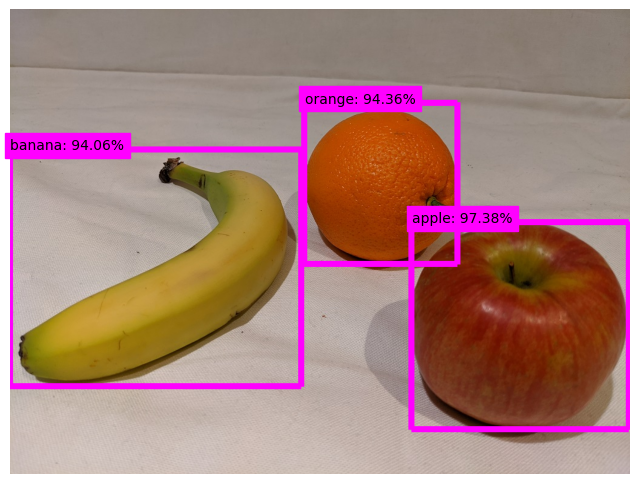

In [6]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

def main():
    from dotenv import load_dotenv

    # Clear the console
    os.system('cls' if os.name=='nt' else 'clear')

    try:
        # Get Configuration Settings
        load_dotenv()
        prediction_endpoint = os.getenv('AZURE_CLAS_PRED_END')
        prediction_key = os.getenv('AZURE_CLAS_PRED_KEY')
        project_id = os.getenv('AZURE_DET_PID')
        model_name = os.getenv('AZURE_DET_PRED_MODEL')

        # Authenticate a client for the training API
        credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
        prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

        # Detect objects in the image
        image_file = 'additional files/produce.jpg'
        print('Detecting objects in', image_file)
        with open(image_file, mode="rb") as image_data:
            results = prediction_client.detect_image(project_id, model_name, image_data)

        # Loop over each prediction
        for prediction in results.predictions:
            # Get each prediction with a probability > 50%
            if (prediction.probability*100) > 50:
                print(prediction.tag_name)

        # Create and save an annotated image
        save_tagged_images(image_file, results.predictions)

    except Exception as ex:
        print(ex)

def save_tagged_images(source_path, detected_objects):
    #Load the image using Pillow
    image = Image.open(source_path)
    h, w, ch = np.array(image).shape
    # Create a figure for the results
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')

    # Display the image with boxes around each detected object
    draw = ImageDraw.Draw(image)
    lineWidth = int(w/100)
    color = 'magenta'
    for detected_object in detected_objects:
        # Only show objects with a > 50% probability
        if (detected_object.probability*100) > 50:
            # Box coordinates and dimensions are proportional - convert to absolutes
            left = detected_object.bounding_box.left * w 
            top = detected_object.bounding_box.top * h 
            height = detected_object.bounding_box.height * h
            width =  detected_object.bounding_box.width * w
            # Draw the box
            points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
            draw.line(points, fill=color, width=lineWidth)
            # Add the tag name and probability
            plt.annotate(detected_object.tag_name + ": {0:.2f}%".format(detected_object.probability * 100),(left,top), backgroundcolor=color)
    plt.imshow(image)
    outputfile = 'additional files/output.jpg'
    fig.savefig(outputfile)
    print('Results saved in', outputfile)


if __name__ == "__main__":
    main()


# Analyze video

The Azure Video Indexer service is designed to help you extract information from videos. It provides functionality that you can use for:

- Facial recognition - detecting the presence of individual people in the image. This requires Limited Access approval.
- Optical character recognition - reading text in the video.
- Speech transcription - creating a text transcript of spoken dialog in the video.
- Topics - identification of key topics discussed in the video.
- Sentiment - analysis of how positive or negative segments within the video are.
- Labels - label tags that identify key objects or themes throughout the video.
- Content moderation - detection of adult or violent themes in the video.
- Scene segmentation - a breakdown of the video into its constituent scenes.

```html
<html>
    <header>
        <title>Analyze Video</title>
        <script src="https://breakdown.blob.core.windows.net/public/vb.widgets.mediator.js"></script>
    </header>
    <body>
        <h1>Video Analysis</h1>
        <table>
            <tr>
                <td style="vertical-align:top;">
                    <!--Player widget goes here -->
                    <iframe width="560" height="315" src="https://www.videoindexer.ai/embed/player/a41a745a-7aea-4437-8e64-2b31e6d0f983/ffxncmqy7q/?accessToken=..." frameborder="0" allowfullscreen></iframe>
                </td>
                <td style="vertical-align:top;">
                    <!-- Insights widget goes here -->
                    <iframe width="580" height="780" src="https://www.videoindexer.ai/embed/insights/a41a745a-7aea-4437-8e64-2b31e6d0f983/ffxncmqy7q/?accessToken=..." frameborder="0" allowfullscreen></iframe>
                </td>
            </tr>
        </table>
    </body>
</html>
```

``` powershell
$account_id="YOUR_ACCOUNT_ID"
$api_key="YOUR_API_KEY"
$location="trial

# Clear the console window

cl

# Call the AccessToken method with the API key in the header to get an access token

$token = Invoke-RestMethod -Method "Get" -Uri "https://api.videoindexer.ai/auth/$location/Accounts/$account_id/AccessToken" -Headers @{'Ocp-Apim-Subscription-Key' = $api_key

# Use the access token to make an authenticated call to the Videos method to get a list of videos in the account

Invoke-RestMethod -Method "Get" -Uri "https://api.videoindexer.ai/$location/Accounts/$account_id/Videos?accessToken=$token" | ConvertTo-Json -Depth 6
```